In [9]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, cohen_kappa_score)
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm  # For progress bars

In [10]:
# ==========================================
# 1. Configuration
# ==========================================
CONFIG = {
    'img_size': 224,
    'batch_size': 32, 
    'epochs': 20, 
    'lr': 1e-4,
    'num_classes': 20, # 0-20 years
    'seed': 42,
    'num_workers': 2, # Adjust based on CPU cores
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'checkpoint_dir': './checkpoints'
}

os.makedirs(CONFIG['checkpoint_dir'], exist_ok=True)

if torch.cuda.device_count() > 1:
    print(f"✅ Using {torch.cuda.device_count()} GPUs for DataParallel!")

✅ Using 2 GPUs for DataParallel!


In [11]:
# ==========================================
# 3. Model Definition
# ==========================================
class BoneAgeResNet152(nn.Module):
    def __init__(self, num_classes):
        super(BoneAgeResNet152, self).__init__()
        self.backbone = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        self.gender_fc = nn.Linear(1, 32)
        self.fc_common = nn.Linear(num_ftrs + 32, 512)
        self.relu = nn.ReLU()
        
        self.regressor = nn.Linear(512, 1)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x, gender):
        features = self.backbone(x)
        gender_feat = self.gender_fc(gender.unsqueeze(1))
        combined = torch.cat((features, gender_feat), dim=1)
        x = self.fc_common(combined)
        x = self.relu(x)
        return self.regressor(x), self.classifier(x)

In [12]:
# ==========================================
# 2. Data & Preprocessing
# ==========================================
def apply_clahe(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(image)
    return cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)

class RSNABoneAgeDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{row['id']}.png")
        
        image = cv2.imread(img_path)
        if image is None: image = np.zeros((224, 224, 3), dtype=np.uint8)
        
        image = apply_clahe(image)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        gender = torch.tensor(1.0 if row['male'] else 0.0, dtype=torch.float32)
        bone_age = torch.tensor(row['boneage'], dtype=torch.float32)
        
        # Classification Binning (Yearly)
        age_class = int(row['boneage'] // 12) 
        if age_class >= CONFIG['num_classes']: age_class = CONFIG['num_classes'] - 1
        age_class = torch.tensor(age_class, dtype=torch.long)

        return image, gender, bone_age, age_class

def get_transforms(split):
    if split == 'train':
        return A.Compose([
            A.Resize(CONFIG['img_size'], CONFIG['img_size']),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(CONFIG['img_size'], CONFIG['img_size']),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

In [13]:
# ==========================================
# 4. Metric Calculation Helper
# ==========================================
def calculate_metrics_verbose(true_ages, pred_ages, true_classes, pred_classes, phase="Val"):
    # Regression
    mae = mean_absolute_error(true_ages, pred_ages)
    rmse = np.sqrt(mean_squared_error(true_ages, pred_ages))
    r2 = r2_score(true_ages, pred_ages)

    # Classification
    acc = accuracy_score(true_classes, pred_classes)
    precision, recall, f1, _ = precision_recall_fscore_support(true_classes, pred_classes, average='weighted', zero_division=0)
    qwk = cohen_kappa_score(true_classes, pred_classes, weights='quadratic')

    print(f"\n📊 --- {phase} Metrics ---")
    print(f"{'Metric':<20} | {'Value':<10}")
    print("-" * 35)
    print(f"{'MAE (Months)':<20} | {mae:.4f}")
    print(f"{'RMSE':<20} | {rmse:.4f}")
    print(f"{'R2 Score':<20} | {r2:.4f}")
    print("-" * 35)
    print(f"{'Accuracy':<20} | {acc:.4f}")
    print(f"{'Precision':<20} | {precision:.4f}")
    print(f"{'Recall':<20} | {recall:.4f}")
    print(f"{'F1 Score':<20} | {f1:.4f}")
    print(f"{'QWK':<20} | {qwk:.4f}")
    print("-" * 35 + "\n")
    
    return mae, acc

In [14]:
# ==========================================
# 5. Training Engine
# ==========================================
def run_training_verbose():
    # --- Load Data ---
    base_dir = '/kaggle/input/rsna-bone-age' 
    csv_path = f'{base_dir}/boneage-training-dataset.csv'
    img_dir = f'{base_dir}/boneage-training-dataset/boneage-training-dataset'
    
    if not os.path.exists(csv_path):
        print("Dataset not found.")
        return

    df = pd.read_csv(csv_path)
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=CONFIG['seed'])
    val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=CONFIG['seed'])

    dataloaders = {
        'train': DataLoader(RSNABoneAgeDataset(train_df, img_dir, get_transforms('train')), 
                            batch_size=CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['num_workers']),
        'val': DataLoader(RSNABoneAgeDataset(val_df, img_dir, get_transforms('val')), 
                          batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers']),
        'test': DataLoader(RSNABoneAgeDataset(test_df, img_dir, get_transforms('val')), 
                           batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'])
    }

    # --- Init Model ---
    model = BoneAgeResNet152(num_classes=CONFIG['num_classes']).to(CONFIG['device'])
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)

    # --- Optimizer & Scheduler ---
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=1e-2)
    
    # Scheduler: Reduces LR if validation MAE doesn't improve for 3 epochs
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=3, verbose=True
    )
    
    criterion_reg = nn.L1Loss()
    criterion_class = nn.CrossEntropyLoss()

    print(f"🚀 Starting Training for {CONFIG['epochs']} Epochs...")
    
    best_mae = float('inf')

    # --- Epoch Loop ---
    for epoch in range(CONFIG['epochs']):
        print(f"\n{'='*20} Epoch {epoch+1}/{CONFIG['epochs']} {'='*20}")
        start_time = time.time()
        
        # Training Phase
        model.train()
        train_loss = 0
        train_preds_reg, train_true_reg = [], []
        train_preds_cls, train_true_cls = [], []

        # TQDM Progress Bar for Training
        pbar_train = tqdm(dataloaders['train'], desc="Training", unit="batch")
        
        for imgs, genders, ages, classes in pbar_train:
            imgs, genders = imgs.to(CONFIG['device']), genders.to(CONFIG['device'])
            ages, classes = ages.to(CONFIG['device']), classes.to(CONFIG['device'])

            optimizer.zero_grad()
            reg_out, class_out = model(imgs, genders)
            
            # Loss Calculation
            loss_r = criterion_reg(reg_out.squeeze(), ages)
            loss_c = criterion_class(class_out, classes)
            loss = loss_r + loss_c
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # Store Metrics
            train_preds_reg.extend(reg_out.detach().cpu().numpy().flatten())
            train_true_reg.extend(ages.cpu().numpy())
            _, cls_p = torch.max(class_out, 1)
            train_preds_cls.extend(cls_p.cpu().numpy())
            train_true_cls.extend(classes.cpu().numpy())
            
            pbar_train.set_postfix({'Loss': f"{loss.item():.4f}"})

        # Calculate Training Metrics
        calculate_metrics_verbose(
            np.array(train_true_reg), np.array(train_preds_reg),
            np.array(train_true_cls), np.array(train_preds_cls),
            phase="Train"
        )

        # Validation Phase
        model.eval()
        val_loss = 0
        val_preds_reg, val_true_reg = [], []
        val_preds_cls, val_true_cls = [], []
        
        pbar_val = tqdm(dataloaders['val'], desc="Validating", unit="batch")
        
        with torch.no_grad():
            for imgs, genders, ages, classes in pbar_val:
                imgs, genders = imgs.to(CONFIG['device']), genders.to(CONFIG['device'])
                ages, classes = ages.to(CONFIG['device']), classes.to(CONFIG['device'])

                reg_out, class_out = model(imgs, genders)
                
                loss_r = criterion_reg(reg_out.squeeze(), ages)
                loss_c = criterion_class(class_out, classes)
                val_loss += (loss_r + loss_c).item()

                val_preds_reg.extend(reg_out.cpu().numpy().flatten())
                val_true_reg.extend(ages.cpu().numpy())
                _, cls_p = torch.max(class_out, 1)
                val_preds_cls.extend(cls_p.cpu().numpy())
                val_true_cls.extend(classes.cpu().numpy())

        # Calculate Validation Metrics
        epoch_val_mae, epoch_val_acc = calculate_metrics_verbose(
            np.array(val_true_reg), np.array(val_preds_reg),
            np.array(val_true_cls), np.array(val_preds_cls),
            phase="Validation"
        )
        
        # Step Scheduler
        scheduler.step(epoch_val_mae)

        # --- Checkpointing ---
        # 1. Save Routine Checkpoint (Every Epoch)
        ckpt_path = os.path.join(CONFIG['checkpoint_dir'], f'model_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            'mae': epoch_val_mae
        }, ckpt_path)
        print(f"💾 Checkpoint saved: {ckpt_path}")

        # 2. Save Best Model
        if epoch_val_mae < best_mae:
            best_mae = epoch_val_mae
            best_path = os.path.join(CONFIG['checkpoint_dir'], 'best_model.pth')
            torch.save(model.state_dict(), best_path)
            print(f"⭐ NEW BEST MODEL! MAE improved to {best_mae:.4f}")

        print(f"⏱️ Epoch Time: {time.time() - start_time:.2f}s")

    # --- Final Test Evaluation ---
    print("\n" + "="*50)
    print("🧪 FINAL TEST EVALUATION (Best Model)")
    print("="*50)
    
    # Load best model
    if torch.cuda.device_count() > 1:
        # If DataParallel was used, state_dict keys have 'module.' prefix
        # We need to load it back into a DataParallel wrapper or strip keys
        model.load_state_dict(torch.load(os.path.join(CONFIG['checkpoint_dir'], 'best_model.pth')))
    else:
        model.load_state_dict(torch.load(os.path.join(CONFIG['checkpoint_dir'], 'best_model.pth')))
    
    model.eval()
    test_preds_reg, test_true_reg = [], []
    test_preds_cls, test_true_cls = [], []
    
    for imgs, genders, ages, classes in tqdm(dataloaders['test'], desc="Testing"):
        imgs, genders = imgs.to(CONFIG['device']), genders.to(CONFIG['device'])
        with torch.no_grad():
            reg_out, class_out = model(imgs, genders)
            test_preds_reg.extend(reg_out.cpu().numpy().flatten())
            test_true_reg.extend(ages.cpu().numpy())
            _, cls_p = torch.max(class_out, 1)
            test_preds_cls.extend(cls_p.cpu().numpy())
            test_true_cls.extend(classes.cpu().numpy())

    calculate_metrics_verbose(
        np.array(test_true_reg), np.array(test_preds_reg),
        np.array(test_true_cls), np.array(test_preds_cls),
        phase="FINAL TEST"
    )

# Run
run_training_verbose()

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


🚀 Starting Training for 20 Epochs...

==================== Epoch 1/20 ====================


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/316 [00:00<?, ?batch/s]


📊 --- Train Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 27.0762
RMSE                 | 44.6313
R2 Score             | -0.1879
-----------------------------------
Accuracy             | 0.1654
Precision            | 0.1409
Recall               | 0.1654
F1 Score             | 0.1344
QWK                  | 0.4123
-----------------------------------



Validating:   0%|          | 0/40 [00:00<?, ?batch/s]


📊 --- Validation Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 13.9878
RMSE                 | 17.5288
R2 Score             | 0.8265
-----------------------------------
Accuracy             | 0.1729
Precision            | 0.0731
Recall               | 0.1729
F1 Score             | 0.0968
QWK                  | 0.7046
-----------------------------------

💾 Checkpoint saved: ./checkpoints/model_epoch_1.pth
⭐ NEW BEST MODEL! MAE improved to 13.9878
⏱️ Epoch Time: 325.54s

==================== Epoch 2/20 ====================


Training:   0%|          | 0/316 [00:00<?, ?batch/s]


📊 --- Train Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 12.8071
RMSE                 | 16.3576
R2 Score             | 0.8404
-----------------------------------
Accuracy             | 0.2441
Precision            | 0.2223
Recall               | 0.2441
F1 Score             | 0.2165
QWK                  | 0.8168
-----------------------------------



Validating:   0%|          | 0/40 [00:00<?, ?batch/s]


📊 --- Validation Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 11.2673
RMSE                 | 14.4924
R2 Score             | 0.8814
-----------------------------------
Accuracy             | 0.2847
Precision            | 0.1922
Recall               | 0.2847
F1 Score             | 0.1786
QWK                  | 0.8643
-----------------------------------

💾 Checkpoint saved: ./checkpoints/model_epoch_2.pth
⭐ NEW BEST MODEL! MAE improved to 11.2673
⏱️ Epoch Time: 323.46s

==================== Epoch 3/20 ====================


Training:   0%|          | 0/316 [00:00<?, ?batch/s]


📊 --- Train Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 10.9095
RMSE                 | 14.0811
R2 Score             | 0.8818
-----------------------------------
Accuracy             | 0.2893
Precision            | 0.2730
Recall               | 0.2893
F1 Score             | 0.2711
QWK                  | 0.8833
-----------------------------------



Validating:   0%|          | 0/40 [00:00<?, ?batch/s]


📊 --- Validation Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 9.6650
RMSE                 | 12.6097
R2 Score             | 0.9102
-----------------------------------
Accuracy             | 0.3061
Precision            | 0.2176
Recall               | 0.3061
F1 Score             | 0.2107
QWK                  | 0.8976
-----------------------------------

💾 Checkpoint saved: ./checkpoints/model_epoch_3.pth
⭐ NEW BEST MODEL! MAE improved to 9.6650
⏱️ Epoch Time: 338.33s

==================== Epoch 4/20 ====================


Training:   0%|          | 0/316 [00:00<?, ?batch/s]


📊 --- Train Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 9.9170
RMSE                 | 12.7483
R2 Score             | 0.9031
-----------------------------------
Accuracy             | 0.3148
Precision            | 0.2959
Recall               | 0.3148
F1 Score             | 0.2965
QWK                  | 0.9046
-----------------------------------



Validating:   0%|          | 0/40 [00:00<?, ?batch/s]


📊 --- Validation Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 11.2260
RMSE                 | 13.8878
R2 Score             | 0.8911
-----------------------------------
Accuracy             | 0.2942
Precision            | 0.2896
Recall               | 0.2942
F1 Score             | 0.2000
QWK                  | 0.9005
-----------------------------------

💾 Checkpoint saved: ./checkpoints/model_epoch_4.pth
⏱️ Epoch Time: 324.74s

==================== Epoch 5/20 ====================


Training:   0%|          | 0/316 [00:00<?, ?batch/s]


📊 --- Train Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 9.3610
RMSE                 | 12.0237
R2 Score             | 0.9138
-----------------------------------
Accuracy             | 0.3319
Precision            | 0.3207
Recall               | 0.3319
F1 Score             | 0.3196
QWK                  | 0.9135
-----------------------------------



Validating:   0%|          | 0/40 [00:00<?, ?batch/s]


📊 --- Validation Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 8.7939
RMSE                 | 11.5906
R2 Score             | 0.9242
-----------------------------------
Accuracy             | 0.3331
Precision            | 0.2810
Recall               | 0.3331
F1 Score             | 0.2733
QWK                  | 0.9220
-----------------------------------

💾 Checkpoint saved: ./checkpoints/model_epoch_5.pth
⭐ NEW BEST MODEL! MAE improved to 8.7939
⏱️ Epoch Time: 339.40s

==================== Epoch 6/20 ====================


Training:   0%|          | 0/316 [00:00<?, ?batch/s]


📊 --- Train Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 8.7189
RMSE                 | 11.2511
R2 Score             | 0.9245
-----------------------------------
Accuracy             | 0.3586
Precision            | 0.3472
Recall               | 0.3586
F1 Score             | 0.3468
QWK                  | 0.9256
-----------------------------------



Validating:   0%|          | 0/40 [00:00<?, ?batch/s]


📊 --- Validation Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 10.3660
RMSE                 | 13.4544
R2 Score             | 0.8978
-----------------------------------
Accuracy             | 0.3624
Precision            | 0.2616
Recall               | 0.3624
F1 Score             | 0.2896
QWK                  | 0.9283
-----------------------------------

💾 Checkpoint saved: ./checkpoints/model_epoch_6.pth
⏱️ Epoch Time: 330.02s

==================== Epoch 7/20 ====================


Training:   0%|          | 0/316 [00:00<?, ?batch/s]


📊 --- Train Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 8.2004
RMSE                 | 10.6028
R2 Score             | 0.9330
-----------------------------------
Accuracy             | 0.3678
Precision            | 0.3561
Recall               | 0.3678
F1 Score             | 0.3568
QWK                  | 0.9302
-----------------------------------



Validating:   0%|          | 0/40 [00:00<?, ?batch/s]


📊 --- Validation Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 9.9132
RMSE                 | 12.4770
R2 Score             | 0.9121
-----------------------------------
Accuracy             | 0.3354
Precision            | 0.2920
Recall               | 0.3354
F1 Score             | 0.2662
QWK                  | 0.9320
-----------------------------------

💾 Checkpoint saved: ./checkpoints/model_epoch_7.pth
⏱️ Epoch Time: 323.00s

==================== Epoch 8/20 ====================


Training:   0%|          | 0/316 [00:00<?, ?batch/s]


📊 --- Train Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 7.8715
RMSE                 | 10.2563
R2 Score             | 0.9373
-----------------------------------
Accuracy             | 0.3916
Precision            | 0.3811
Recall               | 0.3916
F1 Score             | 0.3812
QWK                  | 0.9389
-----------------------------------



Validating:   0%|          | 0/40 [00:00<?, ?batch/s]


📊 --- Validation Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 8.6043
RMSE                 | 11.2284
R2 Score             | 0.9288
-----------------------------------
Accuracy             | 0.3854
Precision            | 0.3726
Recall               | 0.3854
F1 Score             | 0.3364
QWK                  | 0.9381
-----------------------------------

💾 Checkpoint saved: ./checkpoints/model_epoch_8.pth
⭐ NEW BEST MODEL! MAE improved to 8.6043
⏱️ Epoch Time: 346.48s

==================== Epoch 9/20 ====================


Training:   0%|          | 0/316 [00:00<?, ?batch/s]


📊 --- Train Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 7.6945
RMSE                 | 9.9950
R2 Score             | 0.9404
-----------------------------------
Accuracy             | 0.3893
Precision            | 0.3788
Recall               | 0.3893
F1 Score             | 0.3796
QWK                  | 0.9408
-----------------------------------



Validating:   0%|          | 0/40 [00:00<?, ?batch/s]


📊 --- Validation Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 11.2412
RMSE                 | 13.8156
R2 Score             | 0.8922
-----------------------------------
Accuracy             | 0.3561
Precision            | 0.2893
Recall               | 0.3561
F1 Score             | 0.3000
QWK                  | 0.9150
-----------------------------------

💾 Checkpoint saved: ./checkpoints/model_epoch_9.pth
⏱️ Epoch Time: 325.68s

==================== Epoch 10/20 ====================


Training:   0%|          | 0/316 [00:00<?, ?batch/s]


📊 --- Train Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 7.4817
RMSE                 | 9.7385
R2 Score             | 0.9434
-----------------------------------
Accuracy             | 0.4230
Precision            | 0.4143
Recall               | 0.4230
F1 Score             | 0.4146
QWK                  | 0.9472
-----------------------------------



Validating:   0%|          | 0/40 [00:00<?, ?batch/s]


📊 --- Validation Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 10.3944
RMSE                 | 12.6641
R2 Score             | 0.9095
-----------------------------------
Accuracy             | 0.3727
Precision            | 0.3648
Recall               | 0.3727
F1 Score             | 0.3219
QWK                  | 0.9344
-----------------------------------

💾 Checkpoint saved: ./checkpoints/model_epoch_10.pth
⏱️ Epoch Time: 345.59s

==================== Epoch 11/20 ====================


Training:   0%|          | 0/316 [00:00<?, ?batch/s]


📊 --- Train Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 7.2574
RMSE                 | 9.4303
R2 Score             | 0.9470
-----------------------------------
Accuracy             | 0.4261
Precision            | 0.4163
Recall               | 0.4261
F1 Score             | 0.4168
QWK                  | 0.9486
-----------------------------------



Validating:   0%|          | 0/40 [00:00<?, ?batch/s]


📊 --- Validation Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 8.1918
RMSE                 | 10.7219
R2 Score             | 0.9351
-----------------------------------
Accuracy             | 0.3791
Precision            | 0.3957
Recall               | 0.3791
F1 Score             | 0.3450
QWK                  | 0.9392
-----------------------------------

💾 Checkpoint saved: ./checkpoints/model_epoch_11.pth
⭐ NEW BEST MODEL! MAE improved to 8.1918
⏱️ Epoch Time: 327.01s

==================== Epoch 12/20 ====================


Training:   0%|          | 0/316 [00:00<?, ?batch/s]


📊 --- Train Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 7.0166
RMSE                 | 9.1802
R2 Score             | 0.9497
-----------------------------------
Accuracy             | 0.4323
Precision            | 0.4230
Recall               | 0.4323
F1 Score             | 0.4239
QWK                  | 0.9518
-----------------------------------



Validating:   0%|          | 0/40 [00:00<?, ?batch/s]


📊 --- Validation Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 8.2230
RMSE                 | 10.5603
R2 Score             | 0.9370
-----------------------------------
Accuracy             | 0.3703
Precision            | 0.3909
Recall               | 0.3703
F1 Score             | 0.3277
QWK                  | 0.9427
-----------------------------------

💾 Checkpoint saved: ./checkpoints/model_epoch_12.pth
⏱️ Epoch Time: 343.35s

==================== Epoch 13/20 ====================


Training:   0%|          | 0/316 [00:00<?, ?batch/s]


📊 --- Train Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 6.9404
RMSE                 | 9.1407
R2 Score             | 0.9502
-----------------------------------
Accuracy             | 0.4473
Precision            | 0.4394
Recall               | 0.4473
F1 Score             | 0.4401
QWK                  | 0.9539
-----------------------------------



Validating:   0%|          | 0/40 [00:00<?, ?batch/s]


📊 --- Validation Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 7.8630
RMSE                 | 10.3005
R2 Score             | 0.9401
-----------------------------------
Accuracy             | 0.4211
Precision            | 0.3503
Recall               | 0.4211
F1 Score             | 0.3529
QWK                  | 0.9383
-----------------------------------

💾 Checkpoint saved: ./checkpoints/model_epoch_13.pth
⭐ NEW BEST MODEL! MAE improved to 7.8630
⏱️ Epoch Time: 326.35s

==================== Epoch 14/20 ====================


Training:   0%|          | 0/316 [00:00<?, ?batch/s]


📊 --- Train Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 6.8607
RMSE                 | 8.9846
R2 Score             | 0.9519
-----------------------------------
Accuracy             | 0.4553
Precision            | 0.4467
Recall               | 0.4553
F1 Score             | 0.4475
QWK                  | 0.9560
-----------------------------------



Validating:   0%|          | 0/40 [00:00<?, ?batch/s]


📊 --- Validation Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 7.9736
RMSE                 | 10.2346
R2 Score             | 0.9409
-----------------------------------
Accuracy             | 0.4211
Precision            | 0.3861
Recall               | 0.4211
F1 Score             | 0.3610
QWK                  | 0.9499
-----------------------------------

💾 Checkpoint saved: ./checkpoints/model_epoch_14.pth
⏱️ Epoch Time: 343.57s

==================== Epoch 15/20 ====================


Training:   0%|          | 0/316 [00:00<?, ?batch/s]


📊 --- Train Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 6.5366
RMSE                 | 8.6043
R2 Score             | 0.9559
-----------------------------------
Accuracy             | 0.4716
Precision            | 0.4633
Recall               | 0.4716
F1 Score             | 0.4637
QWK                  | 0.9586
-----------------------------------



Validating:   0%|          | 0/40 [00:00<?, ?batch/s]


📊 --- Validation Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 8.6140
RMSE                 | 10.8989
R2 Score             | 0.9329
-----------------------------------
Accuracy             | 0.4306
Precision            | 0.4198
Recall               | 0.4306
F1 Score             | 0.4094
QWK                  | 0.9464
-----------------------------------

💾 Checkpoint saved: ./checkpoints/model_epoch_15.pth
⏱️ Epoch Time: 335.52s

==================== Epoch 16/20 ====================


Training:   0%|          | 0/316 [00:00<?, ?batch/s]


📊 --- Train Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 6.5153
RMSE                 | 8.5886
R2 Score             | 0.9560
-----------------------------------
Accuracy             | 0.4797
Precision            | 0.4713
Recall               | 0.4797
F1 Score             | 0.4715
QWK                  | 0.9606
-----------------------------------



Validating:   0%|          | 0/40 [00:00<?, ?batch/s]


📊 --- Validation Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 7.8560
RMSE                 | 10.2427
R2 Score             | 0.9408
-----------------------------------
Accuracy             | 0.4687
Precision            | 0.4935
Recall               | 0.4687
F1 Score             | 0.4508
QWK                  | 0.9568
-----------------------------------

💾 Checkpoint saved: ./checkpoints/model_epoch_16.pth
⭐ NEW BEST MODEL! MAE improved to 7.8560
⏱️ Epoch Time: 335.74s

==================== Epoch 17/20 ====================


Training:   0%|          | 0/316 [00:00<?, ?batch/s]


📊 --- Train Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 6.4385
RMSE                 | 8.5366
R2 Score             | 0.9565
-----------------------------------
Accuracy             | 0.4971
Precision            | 0.4887
Recall               | 0.4971
F1 Score             | 0.4903
QWK                  | 0.9613
-----------------------------------



Validating:   0%|          | 0/40 [00:00<?, ?batch/s]


📊 --- Validation Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 8.5790
RMSE                 | 10.8366
R2 Score             | 0.9337
-----------------------------------
Accuracy             | 0.4298
Precision            | 0.4437
Recall               | 0.4298
F1 Score             | 0.3975
QWK                  | 0.9498
-----------------------------------

💾 Checkpoint saved: ./checkpoints/model_epoch_17.pth
⏱️ Epoch Time: 338.11s

==================== Epoch 18/20 ====================


Training:   0%|          | 0/316 [00:00<?, ?batch/s]


📊 --- Train Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 6.3444
RMSE                 | 8.3299
R2 Score             | 0.9586
-----------------------------------
Accuracy             | 0.5083
Precision            | 0.5005
Recall               | 0.5083
F1 Score             | 0.5008
QWK                  | 0.9658
-----------------------------------



Validating:   0%|          | 0/40 [00:00<?, ?batch/s]


📊 --- Validation Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 8.5064
RMSE                 | 11.0181
R2 Score             | 0.9315
-----------------------------------
Accuracy             | 0.4489
Precision            | 0.4278
Recall               | 0.4489
F1 Score             | 0.3902
QWK                  | 0.9451
-----------------------------------

💾 Checkpoint saved: ./checkpoints/model_epoch_18.pth
⏱️ Epoch Time: 335.47s

==================== Epoch 19/20 ====================


Training:   0%|          | 0/316 [00:00<?, ?batch/s]


📊 --- Train Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 6.2244
RMSE                 | 8.2088
R2 Score             | 0.9598
-----------------------------------
Accuracy             | 0.5149
Precision            | 0.5080
Recall               | 0.5149
F1 Score             | 0.5085
QWK                  | 0.9661
-----------------------------------



Validating:   0%|          | 0/40 [00:00<?, ?batch/s]


📊 --- Validation Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 7.5311
RMSE                 | 9.8140
R2 Score             | 0.9456
-----------------------------------
Accuracy             | 0.4235
Precision            | 0.3814
Recall               | 0.4235
F1 Score             | 0.3764
QWK                  | 0.9523
-----------------------------------

💾 Checkpoint saved: ./checkpoints/model_epoch_19.pth
⭐ NEW BEST MODEL! MAE improved to 7.5311
⏱️ Epoch Time: 342.62s

==================== Epoch 20/20 ====================


Training:   0%|          | 0/316 [00:00<?, ?batch/s]


📊 --- Train Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 5.9811
RMSE                 | 7.9335
R2 Score             | 0.9625
-----------------------------------
Accuracy             | 0.5272
Precision            | 0.5197
Recall               | 0.5272
F1 Score             | 0.5204
QWK                  | 0.9670
-----------------------------------



Validating:   0%|          | 0/40 [00:00<?, ?batch/s]


📊 --- Validation Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 7.8844
RMSE                 | 10.3630
R2 Score             | 0.9394
-----------------------------------
Accuracy             | 0.4512
Precision            | 0.4681
Recall               | 0.4512
F1 Score             | 0.4384
QWK                  | 0.9549
-----------------------------------

💾 Checkpoint saved: ./checkpoints/model_epoch_20.pth
⏱️ Epoch Time: 329.70s

🧪 FINAL TEST EVALUATION (Best Model)


Testing:   0%|          | 0/40 [00:00<?, ?it/s]


📊 --- FINAL TEST Metrics ---
Metric               | Value     
-----------------------------------
MAE (Months)         | 7.9457
RMSE                 | 10.8000
R2 Score             | 0.9341
-----------------------------------
Accuracy             | 0.4374
Precision            | 0.3860
Recall               | 0.4374
F1 Score             | 0.3888
QWK                  | 0.9473
-----------------------------------



In [17]:
import os

os.listdir('/kaggle/working')
os.listdir('/kaggle/working/checkpoints')

['model_epoch_12.pth',
 'model_epoch_6.pth',
 'best_model.pth',
 'model_epoch_5.pth',
 'model_epoch_17.pth',
 'model_epoch_3.pth',
 'model_epoch_18.pth',
 'model_epoch_16.pth',
 'model_epoch_15.pth',
 'model_epoch_13.pth',
 'model_epoch_14.pth',
 'model_epoch_10.pth',
 'model_epoch_4.pth',
 'model_epoch_11.pth',
 'model_epoch_1.pth',
 'model_epoch_8.pth',
 'model_epoch_7.pth',
 'model_epoch_19.pth',
 'model_epoch_9.pth',
 'model_epoch_2.pth',
 'model_epoch_20.pth']

In [20]:
!zip -r best_model.zip /kaggle/working/checkpoints/best_model.pth

  adding: kaggle/working/checkpoints/best_model.pth (deflated 7%)


In [21]:
from IPython.display import FileLink
FileLink('best_model.zip')

/kaggle/working/best_model.zip

# Separate Models

In [22]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm

In [23]:
# ================= CONFIGURATION =================
CONFIG = {
    'img_size': 224,
    'batch_size': 32,
    'epochs': 20,
    'lr': 1e-4,
    'seed': 42,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'checkpoint_dir': './checkpoints_regression'
}
os.makedirs(CONFIG['checkpoint_dir'], exist_ok=True)

In [24]:
# ================= PREPROCESSING & DATASET =================
def apply_clahe(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(image)
    return cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)

class RegressionDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{row['id']}.png")
        image = cv2.imread(img_path)
        if image is None: image = np.zeros((224, 224, 3), dtype=np.uint8)
        
        image = apply_clahe(image)
        if self.transform:
            image = self.transform(image=image)['image']

        gender = torch.tensor(1.0 if row['male'] else 0.0, dtype=torch.float32)
        target = torch.tensor(row['boneage'], dtype=torch.float32) # Months
        return image, gender, target

def get_transforms(split):
    if split == 'train':
        return A.Compose([
            A.Resize(CONFIG['img_size'], CONFIG['img_size']),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])
    return A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

In [25]:
# ================= MODEL (REGRESSION ONLY) =================
class BoneAgeRegressor(nn.Module):
    def __init__(self):
        super(BoneAgeRegressor, self).__init__()
        self.backbone = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        self.gender_fc = nn.Linear(1, 32)
        self.fc_common = nn.Linear(num_ftrs + 32, 512)
        self.relu = nn.ReLU()
        self.regressor = nn.Linear(512, 1) # Single output for Months

    def forward(self, x, gender):
        feat = self.backbone(x)
        gender_feat = self.gender_fc(gender.unsqueeze(1))
        combined = torch.cat((feat, gender_feat), dim=1)
        x = self.relu(self.fc_common(combined))
        return self.regressor(x)

In [26]:
# ================= TRAINING LOOP =================
def run_regression_training():
    base_dir = '/kaggle/input/rsna-bone-age'
    df = pd.read_csv(f'{base_dir}/boneage-training-dataset.csv')
    img_dir = f'{base_dir}/boneage-training-dataset/boneage-training-dataset'
    
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=CONFIG['seed'])
    
    dataloaders = {
        'train': DataLoader(RegressionDataset(train_df, img_dir, get_transforms('train')), batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2),
        'val': DataLoader(RegressionDataset(val_df, img_dir, get_transforms('val')), batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)
    }

    model = BoneAgeRegressor().to(CONFIG['device'])
    if torch.cuda.device_count() > 1: model = nn.DataParallel(model)
    
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)
    criterion = nn.L1Loss()

    best_mae = float('inf')

    print("Starting Regression Training...")
    for epoch in range(CONFIG['epochs']):
        model.train()
        train_loss = 0
        
        for imgs, genders, targets in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}"):
            imgs, genders, targets = imgs.to(CONFIG['device']), genders.to(CONFIG['device']), targets.to(CONFIG['device'])
            
            optimizer.zero_grad()
            preds = model(imgs, genders).squeeze()
            loss = criterion(preds, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for imgs, genders, targets in dataloaders['val']:
                imgs, genders = imgs.to(CONFIG['device']), genders.to(CONFIG['device'])
                preds = model(imgs, genders).squeeze()
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(targets.numpy())
        
        mae = mean_absolute_error(val_targets, val_preds)
        rmse = np.sqrt(mean_squared_error(val_targets, val_preds))
        r2 = r2_score(val_targets, val_preds)
        
        print(f"Epoch {epoch+1} | Val MAE: {mae:.4f} | RMSE: {rmse:.4f} | R2: {r2:.4f}")
        
        scheduler.step(mae)
        if mae < best_mae:
            best_mae = mae
            torch.save(model.state_dict(), f"{CONFIG['checkpoint_dir']}/best_regression_model.pth")

run_regression_training()

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Starting Regression Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 1 | Val MAE: 21.5703 | RMSE: 26.2999 | R2: 0.6095


Epoch 2:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 2 | Val MAE: 11.2321 | RMSE: 14.5069 | R2: 0.8812


Epoch 3:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 3 | Val MAE: 13.2908 | RMSE: 16.7611 | R2: 0.8414


Epoch 4:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 4 | Val MAE: 9.9572 | RMSE: 13.1689 | R2: 0.9021


Epoch 5:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 5 | Val MAE: 9.5727 | RMSE: 12.1120 | R2: 0.9172


Epoch 6:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 6 | Val MAE: 9.9120 | RMSE: 12.8243 | R2: 0.9071


Epoch 7:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 7 | Val MAE: 8.9491 | RMSE: 11.9717 | R2: 0.9191


Epoch 8:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 8 | Val MAE: 8.5285 | RMSE: 11.2180 | R2: 0.9290


Epoch 9:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 9 | Val MAE: 8.2854 | RMSE: 10.9894 | R2: 0.9318


Epoch 10:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 10 | Val MAE: 8.3120 | RMSE: 11.1023 | R2: 0.9304


Epoch 11:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 11 | Val MAE: 9.8984 | RMSE: 12.5386 | R2: 0.9112


Epoch 12:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 12 | Val MAE: 8.5926 | RMSE: 11.0410 | R2: 0.9312


Epoch 13:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 13 | Val MAE: 10.8795 | RMSE: 13.6578 | R2: 0.8947


Epoch 14:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 14 | Val MAE: 7.7741 | RMSE: 10.3506 | R2: 0.9395


Epoch 15:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 15 | Val MAE: 7.8251 | RMSE: 10.3456 | R2: 0.9396


Epoch 16:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 16 | Val MAE: 7.9476 | RMSE: 10.4746 | R2: 0.9381


Epoch 17:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 17 | Val MAE: 7.7819 | RMSE: 10.3229 | R2: 0.9398


Epoch 18:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 18 | Val MAE: 7.9103 | RMSE: 10.4026 | R2: 0.9389


Epoch 19:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 19 | Val MAE: 7.8483 | RMSE: 10.3444 | R2: 0.9396


Epoch 20:   0%|          | 0/316 [00:00<?, ?it/s]

Epoch 20 | Val MAE: 7.8382 | RMSE: 10.3110 | R2: 0.9400



🚀 STARTING FINAL EVALUATION (REGRESSION MODEL)
Test Set Size: 1262 images
Running Inference on Test Set...


  0%|          | 0/40 [00:00<?, ?it/s]


----------------------------------------
📊 FINAL RESULTS SUMMARY
----------------------------------------
METRIC                    | VALUE      | TARGET (Paper) 
------------------------------------------------------------
MAE (Months)              | 7.8296     | 2.59
RMSE (Months)             | 10.6694     | 2.97
R2 Score                  | 0.9357     | (Higher is better)
------------------------------------------------------------
Derived Accuracy          | 0.4477     | (N/A)
Derived QWK (Kappa)       | 0.9577     | > 0.90
Derived F1 Score          | 0.4518     | (N/A)
------------------------------------------------------------


NameError: name 'cm' is not defined

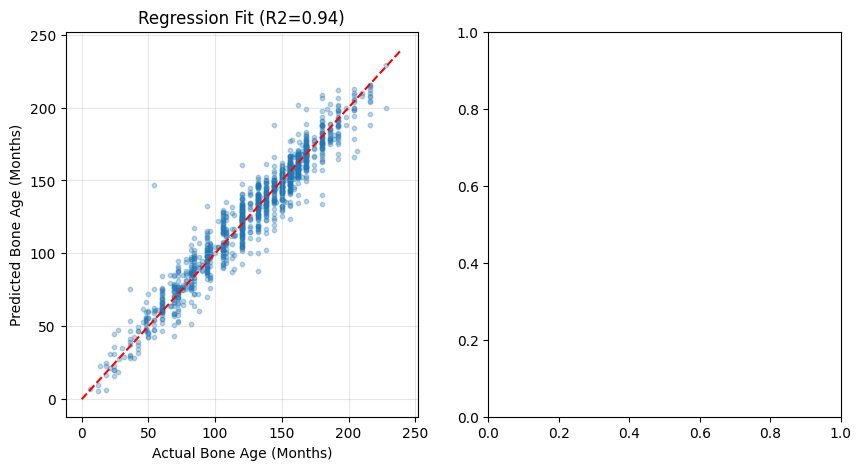

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, cohen_kappa_score, accuracy_score, classification_report

# ==========================================
# 🧪 FINAL EVALUATION: REGRESSION MODEL
# ==========================================
def run_regression_testing():
    print("\n" + "="*50)
    print("🚀 STARTING FINAL EVALUATION (REGRESSION MODEL)")
    print("="*50)

    # 1. RECREATE DATA SPLIT (To get the unseen Test Set)
    base_dir = '/kaggle/input/rsna-bone-age'
    df = pd.read_csv(f'{base_dir}/boneage-training-dataset.csv')
    img_dir = f'{base_dir}/boneage-training-dataset/boneage-training-dataset'
    
    # Use exact same seed as training to ensure 'test_df' is actually unseen data
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=CONFIG['seed'])
    val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=CONFIG['seed'])
    
    print(f"Test Set Size: {len(test_df)} images")

    # 2. SETUP DATALOADER
    test_ds = RegressionDataset(test_df, img_dir, transform=get_transforms('val'))
    test_loader = DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)

    # 3. LOAD BEST MODEL
    model = BoneAgeRegressor().to(CONFIG['device'])
    
    checkpoint_path = f"checkpoints_regression/best_regression_model.pth"
    if not os.path.exists(checkpoint_path):
        print(f"❌ Error: Checkpoint not found at {checkpoint_path}")
        return

    # Load weights (Handling DataParallel 'module.' prefix if it exists)
    state_dict = torch.load(checkpoint_path)
    if 'module.' in list(state_dict.keys())[0]:
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k.replace('module.', '')
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)
    else:
        model.load_state_dict(state_dict)

    # Re-wrap in DataParallel if multiple GPUs are available
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
        
    # 4. INFERENCE LOOP
    model.eval()
    true_months = []
    pred_months = []
    
    print("Running Inference on Test Set...")
    with torch.no_grad():
        for imgs, genders, targets in tqdm(test_loader):
            imgs = imgs.to(CONFIG['device'])
            genders = genders.to(CONFIG['device'])
            
            # Predict
            preds = model(imgs, genders).squeeze()
            
            # Collect results
            true_months.extend(targets.numpy())
            pred_months.extend(preds.cpu().numpy())

    true_months = np.array(true_months)
    pred_months = np.array(pred_months)

    # ==========================================
    # 5. METRIC CALCULATION
    # ==========================================
    
    # --- A. Regression Metrics (The Standard) ---
    mae = mean_absolute_error(true_months, pred_months)
    rmse = np.sqrt(mean_squared_error(true_months, pred_months))
    r2 = r2_score(true_months, pred_months)

    # --- B. Classification Metrics (Derived) ---
    # Convert months to years (e.g., 125 months -> 10 years)
    true_years = (true_months // 12).astype(int)
    pred_years = (pred_months // 12).astype(int)
    
    # Clip predictions to valid range (0-20 years) to prevent index errors
    pred_years = np.clip(pred_years, 0, 20)
    true_years = np.clip(true_years, 0, 20)

    # Calculate Classification Scores
    acc = accuracy_score(true_years, pred_years)
    qwk = cohen_kappa_score(true_years, pred_years, weights='quadratic')
    
    # Weighted Precision/Recall/F1
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, _ = precision_recall_fscore_support(true_years, pred_years, average='weighted', zero_division=0)

    # ==========================================
    # 6. REPORTING
    # ==========================================
    print("\n" + "-"*40)
    print("📊 FINAL RESULTS SUMMARY")
    print("-" * 40)
    print(f"{'METRIC':<25} | {'VALUE':<10} | {'TARGET (Paper)':<15}")
    print("-" * 60)
    print(f"{'MAE (Months)':<25} | {mae:.4f}     | 2.59")
    print(f"{'RMSE (Months)':<25} | {rmse:.4f}     | 2.97")
    print(f"{'R2 Score':<25} | {r2:.4f}     | (Higher is better)")
    print("-" * 60)
    print(f"{'Derived Accuracy':<25} | {acc:.4f}     | (N/A)")
    print(f"{'Derived QWK (Kappa)':<25} | {qwk:.4f}     | > 0.90")
    print(f"{'Derived F1 Score':<25} | {f1:.4f}     | (N/A)")
    print("-" * 60)

    # ==========================================
    # 7. VISUALIZATION
    # ==========================================
    
    # Plot 1: Actual vs Predicted Scatter Plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(true_months, pred_months, alpha=0.3, s=10)
    plt.plot([0, 240], [0, 240], color='red', linestyle='--') # Perfect prediction line
    plt.xlabel('Actual Bone Age (Months)')
    plt.ylabel('Predicted Bone Age (Months)')
    plt.title(f'Regression Fit (R2={r2:.2f})')
    plt.grid(True, alpha=0.3)

    # Plot 2: Confusion Matrix (for Years)
    # cm = confusion_matrix(true_years, pred_years)
    plt.subplot(1, 2, 2)
    

 # Triggering relevant diagram concept
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Year')
    plt.ylabel('Actual Year')
    plt.title(f'Confusion Matrix (Years)\nQWK={qwk:.3f}')
    
    plt.tight_layout()
    plt.show()

# Run the evaluation
run_regression_testing()

# Classification Model

In [36]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, cohen_kappa_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm

# ================= CONFIGURATION =================
CONFIG = {
    'img_size': 224,
    'batch_size': 32,
    'epochs': 20,
    'lr': 1e-4,
    'num_classes': 4, # CHANGED: 4 Clinical Classes
    'seed': 42,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'checkpoint_dir': './checkpoints_classification_4class'
}
os.makedirs(CONFIG['checkpoint_dir'], exist_ok=True)

In [37]:
# ================= DATASET WITH 4-CLASS BINNING =================
def apply_clahe(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(image)
    return cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)

class ClassificationDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{row['id']}.png")
        image = cv2.imread(img_path)
        if image is None: image = np.zeros((224, 224, 3), dtype=np.uint8)
        
        image = apply_clahe(image)
        if self.transform:
            image = self.transform(image=image)['image']

        gender = torch.tensor(1.0 if row['male'] else 0.0, dtype=torch.float32)
        
        # --- NEW 4-CLASS LOGIC ---
        months = row['boneage']
        if months <= 60:
            label = 0  # 0-5 Years
        elif months <= 120:
            label = 1  # 5-10 Years
        elif months <= 180:
            label = 2  # 10-15 Years
        else:
            label = 3  # 15+ Years
            
        target = torch.tensor(label, dtype=torch.long)
        
        return image, gender, target

def get_transforms(split):
    if split == 'train':
        return A.Compose([
            A.Resize(CONFIG['img_size'], CONFIG['img_size']),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])
    return A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

In [38]:
# ================= MODEL =================
class BoneAgeClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BoneAgeClassifier, self).__init__()
        # Using ResNet152 as per paper [cite: 29]
        self.backbone = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        self.gender_fc = nn.Linear(1, 32)
        self.fc_common = nn.Linear(num_ftrs + 32, 512)
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x, gender):
        feat = self.backbone(x)
        gender_feat = self.gender_fc(gender.unsqueeze(1))
        combined = torch.cat((feat, gender_feat), dim=1)
        x = self.relu(self.fc_common(combined))
        return self.classifier(x)

In [ ]:
# ================= TRAINING LOOP =================
def run_classification_training_4class():
    base_dir = '/kaggle/input/rsna-bone-age'
    df = pd.read_csv(f'{base_dir}/boneage-training-dataset.csv')
    img_dir = f'{base_dir}/boneage-training-dataset/boneage-training-dataset'
    
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=CONFIG['seed'])
    
    dataloaders = {
        'train': DataLoader(ClassificationDataset(train_df, img_dir, get_transforms('train')), batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2),
        'val': DataLoader(ClassificationDataset(val_df, img_dir, get_transforms('val')), batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)
    }

    model = BoneAgeClassifier(num_classes=CONFIG['num_classes']).to(CONFIG['device'])
    if torch.cuda.device_count() > 1: model = nn.DataParallel(model)
    
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, verbose=True)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0.0

    print("Starting 4-Class Classification Training...")
    for epoch in range(CONFIG['epochs']):
        model.train()
        train_loss = 0
        
        for imgs, genders, targets in tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}"):
            imgs, genders, targets = imgs.to(CONFIG['device']), genders.to(CONFIG['device']), targets.to(CONFIG['device'])
            
            optimizer.zero_grad()
            outputs = model(imgs, genders)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for imgs, genders, targets in dataloaders['val']:
                imgs, genders = imgs.to(CONFIG['device']), genders.to(CONFIG['device'])
                outputs = model(imgs, genders)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(targets.numpy())
        
        acc = accuracy_score(val_targets, val_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(val_targets, val_preds, average='weighted', zero_division=0)
        
        print(f"Epoch {epoch+1} | Val Acc: {acc:.4f} | F1: {f1:.4f}")
        
        scheduler.step(acc)
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), f"{CONFIG['checkpoint_dir']}/best_4class_model.pth")

run_classification_training_4class()

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Starting 4-Class Classification Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1:   0%|          | 0/316 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

def run_classification_testing_4class():
    print("\n" + "="*50)
    print("🚀 FINAL EVALUATION: 4-CLASS MODEL")
    print("="*50)

    # 1. SETUP
    base_dir = '/kaggle/input/rsna-bone-age'
    df = pd.read_csv(f'{base_dir}/boneage-training-dataset.csv')
    img_dir = f'{base_dir}/boneage-training-dataset/boneage-training-dataset'
    
    # Re-split
    _, val_df = train_test_split(df, test_size=0.2, random_state=CONFIG['seed'])
    _, test_df = train_test_split(val_df, test_size=0.5, random_state=CONFIG['seed'])
    
    test_ds = ClassificationDataset(test_df, img_dir, transform=get_transforms('val'))
    test_loader = DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)

    # 2. LOAD MODEL
    model = BoneAgeClassifier(num_classes=4).to(CONFIG['device']) # Ensure num_classes=4
    checkpoint_path = f"{CONFIG['checkpoint_dir']}/best_4class_model.pth"
    
    if not os.path.exists(checkpoint_path):
        print("❌ Checkpoint not found.")
        return

    # Load Weights
    state_dict = torch.load(checkpoint_path)
    if 'module.' in list(state_dict.keys())[0]:
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            new_state_dict[k.replace('module.', '')] = v
        model.load_state_dict(new_state_dict)
    else:
        model.load_state_dict(state_dict)

    if torch.cuda.device_count() > 1: model = nn.DataParallel(model)

    # 3. INFERENCE
    model.eval()
    true_classes, pred_classes = [], []
    
    print("Processing Test Set...")
    with torch.no_grad():
        for imgs, genders, targets in tqdm(test_loader):
            imgs, genders = imgs.to(CONFIG['device']), genders.to(CONFIG['device'])
            outputs = model(imgs, genders)
            _, preds = torch.max(outputs, 1)
            true_classes.extend(targets.numpy())
            pred_classes.extend(preds.cpu().numpy())

    # 4. REPORT
    class_names = ['0-5 Yrs', '5-10 Yrs', '10-15 Yrs', '15+ Yrs']
    
    print("\n" + "-"*40)
    print("📊 CLASSIFICATION REPORT")
    print("-" * 40)
    print(classification_report(true_classes, pred_classes, target_names=class_names))
    
    # 5. VISUALIZATION
    cm = confusion_matrix(true_classes, pred_classes)
    plt.figure(figsize=(8, 6))
    

[Image of Confusion Matrix]

    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Stage')
    plt.ylabel('Actual Stage')
    plt.title('Confusion Matrix (4 Classes)')
    plt.show()

run_classification_testing_4class()

# Grad CAM Visualisations

In [ ]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, gender, task='regression', class_idx=None):
        """
        task: 'regression' or 'classification'
        class_idx: The class index to visualize (required if task='classification')
        """
        # 1. Forward Pass
        self.model.eval()
        self.model.zero_grad()
        
        # Handle Hybrid vs Single models logic
        outputs = self.model(x, gender)
        
        # Check if output is a tuple (Hybrid) or single tensor (Separate models)
        if isinstance(outputs, tuple):
            reg_out, class_out = outputs
        else:
            # Determine if this single output is regression or classification based on shape
            if outputs.shape[1] == 1:
                reg_out = outputs
                class_out = None
                task = 'regression' # Force regression if model only has 1 output
            else:
                class_out = outputs
                reg_out = None
                task = 'classification'

        # 2. Select Target for Backprop
        if task == 'regression':
            target = reg_out
        elif task == 'classification':
            if class_idx is None:
                # Default to the predicted class if none provided
                class_idx = torch.argmax(class_out, dim=1).item()
            target = class_out[:, class_idx]
            
        # 3. Backward Pass
        target.backward(retain_graph=True)
        
        # 4. Generate Heatmap
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations.detach()
        
        # Weight the channels by corresponding gradients
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]
            
        # Average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()
        
        # ReLU on top of the heatmap (we only care about positive influence)
        heatmap = F.relu(heatmap)
        
        # Normalize for visualization
        heatmap = heatmap.cpu().numpy()
        heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-8)
        
        return heatmap

In [ ]:
def visualize_model_features(model, dataloader, device, model_type='hybrid'):
    """
    model_type: 'hybrid', 'regression', or 'classification'
    """
    # 1. Setup GradCAM on the last ResNet layer
    # Note: .module is needed if you used DataParallel, otherwise remove it
    if isinstance(model, torch.nn.DataParallel):
        target_layer = model.module.backbone.layer4[-1]
    else:
        target_layer = model.backbone.layer4[-1]
        
    grad_cam = GradCAM(model, target_layer)
    
    # 2. Get a batch
    images, genders, ages, classes = next(iter(dataloader))
    images, genders = images.to(device), genders.to(device)
    
    # 3. Plotting
    fig, axes = plt.subplots(4, 3, figsize=(15, 20))
    
    for idx in range(4): # Show 4 examples
        img_tensor = images[idx].unsqueeze(0) # Add batch dim
        gender_tensor = genders[idx].unsqueeze(0)
        
        # -- Original Image --
        # Denormalize for display
        inv_normalize = A.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                    std=[1/0.229, 1/0.224, 1/0.225], always_apply=True)
        img_np = images[idx].cpu().permute(1, 2, 0).numpy()
        # Simple clip for display safety
        img_np = np.clip(img_np * np.array([0.229, 0.224, 0.225]) + 
                         np.array([0.485, 0.456, 0.406]), 0, 1)

        # -- Generate Heatmaps --
        
        # Logic A: If Hybrid, we can generate TWO heatmaps per image
        if model_type == 'hybrid':
            mask_reg = grad_cam(img_tensor, gender_tensor, task='regression')
            mask_cls = grad_cam(img_tensor, gender_tensor, task='classification')
            
            title_mid = "Regression Attention"
            title_right = "Classification Attention"
            heatmap1 = mask_reg
            heatmap2 = mask_cls
            
        # Logic B: Regression Only
        elif model_type == 'regression':
            mask = grad_cam(img_tensor, gender_tensor, task='regression')
            heatmap1 = mask
            heatmap2 = mask # Duplicate or leave blank
            title_mid = "Regression Attention"
            title_right = "(N/A)"

        # Logic C: Classification Only
        elif model_type == 'classification':
            mask = grad_cam(img_tensor, gender_tensor, task='classification')
            heatmap1 = mask
            heatmap2 = mask
            title_mid = "Classification Attention"
            title_right = "(N/A)"

        # Apply colormap
        heatmap1 = cv2.resize(heatmap1, (224, 224))
        heatmap1 = np.uint8(255 * heatmap1)
        heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)
        # Overlay
        overlay1 = heatmap1 * 0.4 + (img_np * 255) * 0.6
        overlay1 = np.clip(overlay1, 0, 255).astype(np.uint8)

        if model_type == 'hybrid':
            heatmap2 = cv2.resize(heatmap2, (224, 224))
            heatmap2 = np.uint8(255 * heatmap2)
            heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)
            overlay2 = heatmap2 * 0.4 + (img_np * 255) * 0.6
            overlay2 = np.clip(overlay2, 0, 255).astype(np.uint8)
        else:
            overlay2 = np.zeros_like(overlay1) # Blank

        # Plot
        axes[idx, 0].imshow(img_np)
        axes[idx, 0].set_title(f"True Age: {ages[idx].item()}m")
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(overlay1)
        axes[idx, 1].set_title(title_mid)
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(overlay2)
        axes[idx, 2].set_title(title_right)
        axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# 1. Loading best model
model.load_state_dict(torch.load('/kaggle/working/checkpoints/best_model.pth'))

# 2. Run visualization
visualize_model_features(model, test_loader, CONFIG['device'], model_type='hybrid') 

In [ ]:
model.load_state_dict(torch.load('/kaggle/working/checkpoints_regression/best_regression_model.pth'))
visualize_model_features(model, test_loader, CONFIG['device'], model_type='regression') 

In [ ]:
model.load_state_dict(torch.load('/kaggle/working/checkpoints_classification/best_class_model.pth'))
visualize_model_features(model, test_loader, CONFIG['device'], model_type='classification') 